In [106]:
from __future__ import division, print_function
from glob import glob
import json
import fitsio

class Artifact(object):
    
    def __init__(self, identifier, expname, ccd, problem, x, y):
        self.ident = identifier
        self.expname = expname
        self.ccd = ccd
        self.problem = problem
        self.x = x
        self.y = y
        

def load_release_artifacts(artifact_base):
    files = glob(artifact_base+'*')
    artifacts = []
    for f in files:
        with open(f, 'r') as fp:
            arts = json.load(fp)
            for art in arts:
                if ~art['false_positive']:
                    ident = '_'.join([art['expname'].split('_')[-1],str(art['ccd'])])
                    oart = Artifact(ident, art['expname'], art['ccd'],\
                                    art['problem'], art['x'], \
                                    art['y'])
                    artifacts.append(oart)

    artifacts.sort(key=lambda x : x.ident)
    artifacts = np.array(artifacts)
    
    return artifacts

def coarsegrain(stamp, factor=8):
    nx, ny = stamp.shape
    cnx = nx//factor
    cny = ny//factor
    
    cgstamp = np.ndarray((cnx, cny))
    for i in np.arange(factor-1):
        stamp[i+1::factor,:] += stamp[i::factor,:]
    for j in np.arange(factor-1):
        stamp[:,j+1::factor] += stamp[:,j::factor]
        
    cgstamp = stamp[factor-1::factor,factor-1::factor]/float(factor**2)
    return(cgstamp)
    

def create_design_matrix(image_glob, bkg_glob, artifacts, gridsize=128, cgfactor=8):
    
    assert((2048%gridsize==0) & (gridsize<=2048))
    nxpixels  = 4096
    nypixels = 2048
    nxgridelem = nxpixels/gridsize
    nygridelem = nypixels/gridsize
    
    edirs = np.array(glob(image_glob))
    bdirs = np.array(glob(bkg_glob))
    eident = []
    bident = []
    for i, d in enumerate(edirs):
        eexpnum = d.split('/')[-1].split('_')
        eexpnum[2] = eexpnum[2].split('.')[0]
        bexpnum = bdirs[i].split('/')[-1].split('_')
        eident.append('_'.join(eexpnum[1:3]))
        bident.append('_'.join(bexpnum[1:3]))
    
    aident = np.array([a.ident for a in artifacts])
    eident = np.array(eident)
    bident = np.array(bident)
    assert(len(eident)==len(bident))
    
    eidx = eident.argsort()
    bidx = bident.argsort()
    
    eident = eident[eidx]
    edirs = edirs[eidx]
    bident = bident[bidx]
    bdirs = bdirs[bidx]
    
    features = []
    labels = []
    imgcache = None
    xgrid = np.arange(0,nxpixels-1,gridsize)
    ygrid = np.arange(0,nypixels-1,gridsize)
    
    aidx = np.searchsorted(aident, eident[0])
    for i, e in enumerate(eident):
        assert(e==bident[i])
        exp = fitsio.read(edirs[i], ext=1)
        msk = fitsio.read(edirs[i], ext=2)
        #wgt = fitsio.read(edirs[i], ext=3) maybe use weights later
        bkg = fitsio.read(bdirs[i], ext=1)
        mbse = (exp-bkg)
        mbse[msk>np.min(msk)] = -99

        for j, xb in enumerate(xgrid):
            for k, yb in enumerate(ygrid):
                if (j>(len(xgrid)-1)) or (k>(len(ygrid)-1)): continue
                stamp = coarsegrain(mbse[xb:(xb+gridsize),yb:(yb+gridsize)], cgfactor).flatten()
                features.append(stamp)
                tidx = aidx
                problems = []
                while(str(artifacts[tidx].ident)==str(e)):
                    a = artifacts[tidx] 
                    #Include artifacts near the edges of 
                    #the grid in all pixels near that edge?
                    if (((xb<=a.x) & (a.x<(xb+gridsize))) &\
                        ((yb<=a.y) & (a.y<(yb+gridsize)))):
                        problems.append(a.problem)
                    tidx+=1
                #for now, keep only one artifact per grid element
                if len(problems)>0:
                    labels.append(problems[0])
                else:
                    labels.append('no_artifacts')

        aidx+=(tidx-aidx)
    
    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels

def enumerate_labels(labels):
    atype = ['Column_mask', 'Cosmic_ray', 'Cross-talk', 'Edge-bleed', 'Excessive_mask', 'Dark_rim',
         'Dark_halo', 'Quilted_sky', 'Wavy_sky', 'Anti-bleed', 'AB_jump', 'Fringing', 'Tape_bump',
         'Tree_rings', 'Vertical_jump', 'Ghost', 'Bright_spray', 'Brush_strokes', 'Bright_arc',
         'Satellite', 'Airplane', 'Guiding', 'Shutter', 'Readout', 'Haze', 'Vertical_stripes',
         'Other...', 'Awesome!', 'no_artifacts']
    nums = range(1,len(atype)+1)
    ldict = dict(zip(atype,nums))
    enumlabels = np.array([ldict[l] for l in labels])
    
    return enumlabels

In [27]:
artifacts = load_release_artifacts('/nfs/slac/g/ki/ki23/des/jderose/des/se_exposures/metadata/Y1A1/')

In [28]:
eglob = '/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/20140623140130_20130914/red/*/DECam_*_*[0-9].fits.fz'
bglob = '/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/20140623140130_20130914/red/*/DECam_*_*[0-9]_bkg.fits.fz'

In [107]:
X, y = create_design_matrix(eglob, bglob, artifacts, gridsize=2048)

In [4]:
img = fitsio.read(glob(eglob)[0], ext=1)
msk = fitsio.read(glob(eglob)[0], ext=2)

In [21]:
img[msk>np.min(msk)] = -99

In [23]:
img.dtype

dtype('float32')

Populating the interactive namespace from numpy and matplotlib


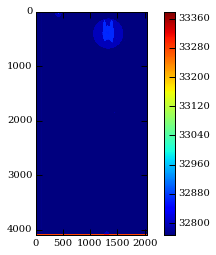

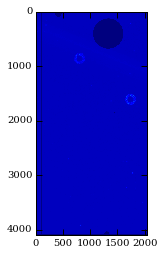

In [25]:
%pylab inline
plt.imshow(msk)
colorbar()
figure()
imshow(img)

In [30]:
from sklearn import svm

In [109]:
ey = enumerate_labels(y)

In [112]:
clf = svm.SVC(kernel='linear')

In [113]:
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [114]:
clf.predict(X[ey<max(ey),:])

array([u'Airplane', u'Airplane'], 
      dtype='<U12')

In [115]:
y[ey<max(ey)]

array([u'Airplane', u'Airplane'], 
      dtype='<U12')

In [65]:
airplanes = [True if str(a.problem)==str('Airplane') else False for a in artifacts]

In [67]:
artifacts[airplanes][0].problem

/nfs/slac/g/ki/ki21/cosmo/jderose/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


u'Dark rim'

In [70]:
problems = np.array([a.problem for a in artifacts])

In [76]:
idents = [a.ident for a in artifacts[problems=='Airplane']]

In [125]:
apexp = glob('/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/*/red/DECam_00234124/DECam_*_*58.fits.fz')
apbkg = glob('/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/*/red/DECam_00234124/DECam_*_*58_bkg.fits.fz')

In [129]:
aX, ay = create_design_matrix('/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/*/red/DECam_00234124/DECam_*_*58.fits.fz', '/nfs/slac/g/ki/ki21/cosmo/DESDATA/OPS/red/*/red/DECam_00234124/DECam_*_*58_bkg.fits.fz', artifacts, gridsize=2048)

In [91]:
aimg = fitsio.read(apexp[0], ext=1)
abkg = fitsio.read(apbkg[0])

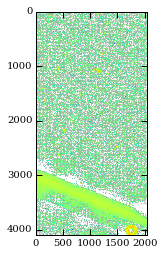

In [95]:
from matplotlib.colors import LogNorm
plt.imshow(aimg-abkg, norm=LogNorm())

In [130]:
yp = clf.predict(aX)

In [131]:
np.where(yp=='Airplane')

(array([0]),)

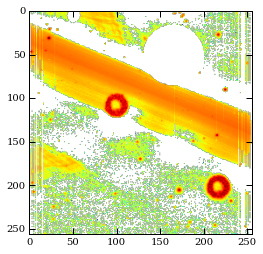

In [133]:
imshow(X[0].reshape(256,256), norm=LogNorm())

In [136]:
len(clf.support_vectors_)

265

In [137]:
len(X)

1920